# Multi-Armed Bandit (k-Armed Bandit)


## References

* https://en.wikipedia.org/wiki/Multi-armed_bandit
* https://arxiv.org/abs/1904.07272

In [1]:
from datetime import timedelta, datetime
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, clear_output

## Introduction

* Iteratively selects one of the multiple fixed choices, These choices are called `arms` or `actions` or `levers`
* Property of each choice is partially known at the time of allocation but become better understood as the time passes.
    * Either we know it earlier (Partially)
    * or we'll know it with time
* these arms are `Independent`
* This algorithm works as `Best Arm Identification`
* Target here is to `Minimize Regret`
* Exploration $\leftrightarrow$ Exploitation

> Objective
>> `Maximize` the sum of rewards earned through a sequence of arm pulls.
>>
>> Each machines provides a random reward from a probability distribution specific to the machine(not known apriori)



### Reward Models

| Reward | Description |
|-|-|
| IID(Independent & Identically Distributed) Rewards | Reward from each arm is drawn independently from a fixed distribution that depends on the `arm` and not the `round t` | 
| Adverserial Rewards | Rewards can be arbitrary as they are chosen by an `adversary` trying to fool the algorithm, May be oblivious or adaptive | 
| Constrained Adversary | Rewards are chosen from an adversary that is subjected to some constraint | 
| Random Process Rewards | An arm's state, which determines reward, evolves over time as a random process state transition |

### Feedbacks

| Feedback | Description | 
|-|-|
| Bandit Feedback | algorithm observes the reward only for chosen arm | 
| Full Feedback | algorithm observes the reward for all the arms that could have been chosen | 
| Partial Feedback | some info is revealed + reward from the chosen arm (doesn't always amount to full feedback)

### Contexts 

* Algorithm may observe context before chosing an arm
* Personalized actions

> News Website : user location & demographics

> Dynamic Pricing : customer's device, location, demographics

### Bayesian Priors

Problem instance comes from known distribution called Bayesian Prior

## Stochastic Bandits

* IID Rewards
* $K$ Possible Arms/ Actions
* $T$ Rounds
* Maximize total Reward over T rounds
* Algorithm observes reward only from selected arms `Bandit Feedback`


## Arms : $K$

* Possible actions/arms 
* Follows IID
* Chosen over T rounds

In [2]:
class Arms:
    @staticmethod
    def arm_1(mu=10, sigma=5):
        return np.random.normal(mu, sigma)

    @staticmethod
    def arm_2(mu=8, sigma=3):
        return np.random.normal(mu, sigma)

    @staticmethod
    def arm_3(mu=5, sigma=25):
        return np.random.normal(mu, sigma)


arms = ["arm_1", "arm_2", "arm_3"]

In [3]:
def arms_cyclic_iter(arms):
    i = 0
    while True:
        if i >= len(arms):
            i = 0
        yield arms[i]
        i += 1
        
def print_df(df, sleep_time):
    clear_output(wait=True)
    display(df)
    time.sleep(sleep_time)

In [4]:
def random_choose_arm(arms, size=None, replace=True, p=None):
    return np.random.choice(arms, size=size, replace=replace, p=p)

## Reward Distribution : $D_a$

* Reward for each action is IID, for each action $a$ there is a distribution $D_a$ called `Reward Distribution`
* Each time the action is chosen and the reward is sampled from a dsitribution that is `Initially Unknown`
* $K$ arms, $T$ rounds (Known), $D_a$ for arm $a$ (unknown)
* at $t \in [T]$
    * pick arm $a_t$
    * reward $r_t \in [0, 1]$ sampled from $D_a, a=a_t$
    * collects reward $r_t$ & observes nothing else
* Mean reward value $\mu \in [0, 1]$
* $\mu(a) = \mathbb{E}[D_a]$ (Mean of reward from action = expected value for reward distribution)
* Example Bernoulli Distribution

* below example of reward distribution is not bound in [0, 1] but shows different arms with different rewards distribution


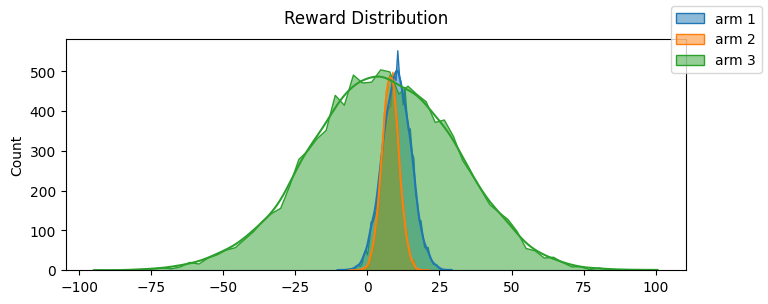

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

params = {
    "kde": True,
    "element": "poly",
    "ax": ax,
}
sns.histplot([Arms.arm_1() for _ in range(10000)], label="arm 1", **params)
sns.histplot([Arms.arm_2() for _ in range(10000)], label="arm 2", **params)
sns.histplot([Arms.arm_3() for _ in range(10000)], label="arm 3", **params)

fig.suptitle("Reward Distribution")
fig.legend()
fig.show()

## Best Mean Reward/ Optimum Reward : $\mu^*$

\begin{align}
\mu(a) &= \mathbb{E}[D_a] \\
\text{Optimum Reward } \mu^* &= {\text{max}\atop{a \in \mathbb{A}}} \mu(a)
\end{align}

## Gap in Arm : $\Delta(a)$

gap in arm a is defined as difference of best mean reward and reward of action a
\begin{align}
\Delta(a) &:= \mu^* - \mu(a)
\end{align}

## Best Arm/ Optimal Arm : $a^*$

optimal arm is arm with best mean reward

\begin{align}
a^* &:= \mu(a) = \mu^* \rightarrow \Delta(a) \approx 0
\end{align}

In [6]:
def optimal_arm(df, best_mean_reward):
    return df[df["reward_mean"] == best_mean_reward]["arm"].iloc[0]

## Regret : $R(T)$

* Compare cumulative reward (Mean reward at t step cumulative sum till round T) to best arm benchmark (Best Mean Reward T Rounds times), what if we play same best arm for all rounds $T$. (Always playing optimal arm)
\begin{align}
\text{Regret at round T} \\
R(T) = \mu^* . T - \Sigma_{t=1}^{T} \mu(a_t) \\
\end{align}


In [7]:
def calculate_regret(cumulative_reward, best_mean_reward, T):
    best_arm_benchmark = best_mean_reward * T
    regret = best_arm_benchmark - cumulative_reward
    return regret

In [8]:
def get_metrics(rewardsdf: pd.DataFrame, verbose=True):
    aggdf = (
        rewardsdf.groupby(by=["arm", "decision"], as_index=False)
        .agg(
            ts_count=("ts", "count"),
            ts_min=("ts", "min"),
            reward_min=("reward", "min"),
            reward_mean=("reward", "mean"),
            reward_max=("reward", "max"),
            reward_sum=("reward", "sum"),
            reward_std=("reward", "std"),
        )
        .sort_values(by=["ts_min"])
    )

    best_mean_reward = aggdf["reward_mean"].max()
    cumulative_reward = aggdf["reward_sum"].sum()
    T = aggdf["ts_count"].sum()

    optimum_reward = best_mean_reward * T

    best_arm = optimal_arm(aggdf, best_mean_reward)

    regret = calculate_regret(
        cumulative_reward=cumulative_reward, best_mean_reward=best_mean_reward, T=T
    )
    if verbose:
        print_df(aggdf, 0.2)
        print(
            f"""
        Rounds              : {T}
        Optimum Reward      : {optimum_reward}
        Cumulative Reward   : {cumulative_reward} 
        Regret              : {regret}
        """
        )
    return (best_arm, aggdf, optimum_reward, cumulative_reward, regret)

In [9]:
def plot_reward(rewarddf, x="ts"):
    rewarddf["decision-arm"] = rewarddf["decision"] + "-" + rewarddf["arm"]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    line_plot_params = {
        "alpha": 0.6,
        "color": "grey",
        "linewidth": 0.5,
    }

    sns.lineplot(data=rewarddf, x=x, y="reward", ax=ax[0], **line_plot_params)
    sns.scatterplot(data=rewarddf, x=x, y="reward", hue="decision-arm", ax=ax[0])

    sns.lineplot(data=rewarddf, x=x, y="reward_cumsum", ax=ax[1], **line_plot_params)
    sns.scatterplot(
        data=rewarddf, x=x, y="reward_cumsum", hue="decision-arm", ax=ax[1]
    )

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    return fig

## Model

Code below is a rudimentary implementation of how a MAB model will collect data and fit distribution.

In [10]:
class Model:
    def __init__(self, arms) -> None:
        self.ts_idx = datetime(2024, 1, 1, 0, 0, 0)
        self.timedelta = timedelta(minutes=30)
        self.seq_idx = 0
        self.decision_idx = 0
        self.rewards = pd.DataFrame(
            columns=["decision_idx", "decision", "seq", "ts", "arm", "reward"]
        )
        self.arms = arms
        self.chosen_arm = None

    def get_decision_idx(self, decision):

        if (
            len(self.rewards) == 0
            or self.rewards["decision"].iloc[len(self.rewards) - 1] != decision
        ):
            self.decision_idx += 1
        return self.decision_idx

    def get_arm(self):
        if self.chosen_arm is None:
            if len(self.rewards) == 0:
                raise ValueError("First run explore to get some data")
            self.chosen_arm = get_metrics(self.rewards, verbose=False)[0]
        return self.chosen_arm

    def update_rewards(self, reward_payload):
        self.rewards.loc[len(self.rewards)] = reward_payload
        print_df(self.rewardsdf, 0.2)

    def explore(self, enforce_arm=None):
        self.chosen_arm = None
        explore_arm = enforce_arm or random_choose_arm(self.arms)
        reward = getattr(Arms, explore_arm)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "explore"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            [decision_idx, decision, self.seq_idx, self.ts_idx, explore_arm, reward]
        )

    def exploit(self):
        chosen_arm = self.get_arm()
        reward = getattr(Arms, chosen_arm)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "exploit"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            [decision_idx, decision, self.seq_idx, self.ts_idx, chosen_arm, reward]
        )

    @property
    def rewardsdf(self):
        df = self.rewards.copy()
        df.insert(len(df.columns), column="reward_cumsum", value=df["reward"].cumsum())
        return df

## Only Exploration

### Algorithm

> 1. $K$ arms, $T$ rounds
>
> 2. In each round $t \in T$
>
>> 1. Algorithm picks an arm $a_t$ (Stochastic/ Sequential)
>>
>> 2. Reward $r_t$ is sampled/observed from distribution $D_a$ where $a=a_T$
>>
>> 3. Algorithm collects reward $r_t$, observes nothing else(Bandit feedback)


### Stochastic

In [11]:
model = Model(arms)

for _ in range(100):
    model.explore()

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_3,-11.788321,-11.788321
1,1,explore,2,2024-01-01 01:00:00,arm_2,12.088685,0.300363
2,1,explore,3,2024-01-01 01:30:00,arm_1,9.827448,10.127812
3,1,explore,4,2024-01-01 02:00:00,arm_2,10.922434,21.050246
4,1,explore,5,2024-01-01 02:30:00,arm_1,8.885288,29.935534
...,...,...,...,...,...,...,...
95,1,explore,96,2024-01-03 00:00:00,arm_3,-1.721018,854.314202
96,1,explore,97,2024-01-03 00:30:00,arm_3,6.783670,861.097873
97,1,explore,98,2024-01-03 01:00:00,arm_3,-39.009226,822.088647
98,1,explore,99,2024-01-03 01:30:00,arm_2,10.385623,832.474270


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
2,arm_3,explore,40,2024-01-01 00:30:00,-40.480190,8.119206,46.224011,324.768249,23.625556
1,arm_2,explore,37,2024-01-01 01:00:00,1.412995,8.095527,13.555356,299.534482,3.103868
0,arm_1,explore,23,2024-01-01 01:30:00,3.240814,9.674097,18.647836,222.504220,4.188599



        Rounds              : 100
        Optimum Reward      : 967.4096520112096
        Cumulative Reward   : 846.806950843292 
        Regret              : 120.60270116791753
        


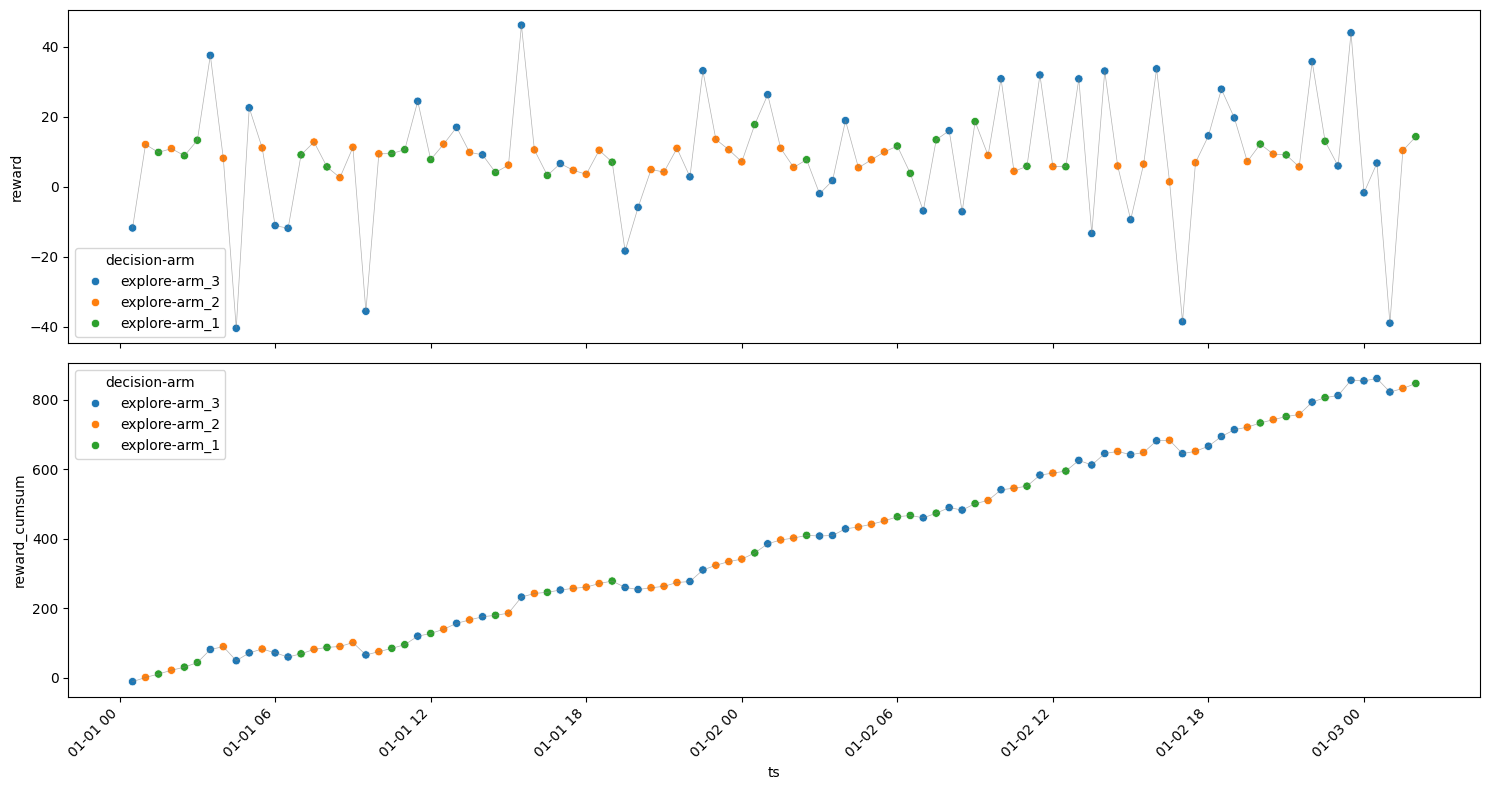

In [12]:
explore_rewarddf = model.rewardsdf
get_metrics(explore_rewarddf)
plot_reward(explore_rewarddf);

### Sequential

In [13]:
arms_iterator = arms_cyclic_iter(arms)
model = Model(arms)

for _ in range(100):
    model.explore(next(arms_iterator))

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_1,14.717441,14.717441
1,1,explore,2,2024-01-01 01:00:00,arm_2,10.151536,24.868977
2,1,explore,3,2024-01-01 01:30:00,arm_3,34.513253,59.382230
3,1,explore,4,2024-01-01 02:00:00,arm_1,7.857376,67.239606
4,1,explore,5,2024-01-01 02:30:00,arm_2,9.939486,77.179092
...,...,...,...,...,...,...,...
95,1,explore,96,2024-01-03 00:00:00,arm_3,-0.086446,699.868702
96,1,explore,97,2024-01-03 00:30:00,arm_1,11.695269,711.563971
97,1,explore,98,2024-01-03 01:00:00,arm_2,3.749240,715.313211
98,1,explore,99,2024-01-03 01:30:00,arm_3,-5.496441,709.816770


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,arm_1,explore,34,2024-01-01 00:30:00,-0.531654,10.507842,19.903238,357.266638,4.991634
1,arm_2,explore,33,2024-01-01 01:00:00,0.727823,8.089693,14.239782,266.959881,3.288865
2,arm_3,explore,33,2024-01-01 01:30:00,-47.006049,3.086514,54.848921,101.854976,25.057924



        Rounds              : 100
        Optimum Reward      : 1050.784229925647
        Cumulative Reward   : 726.0814956762381 
        Regret              : 324.7027342494089
        


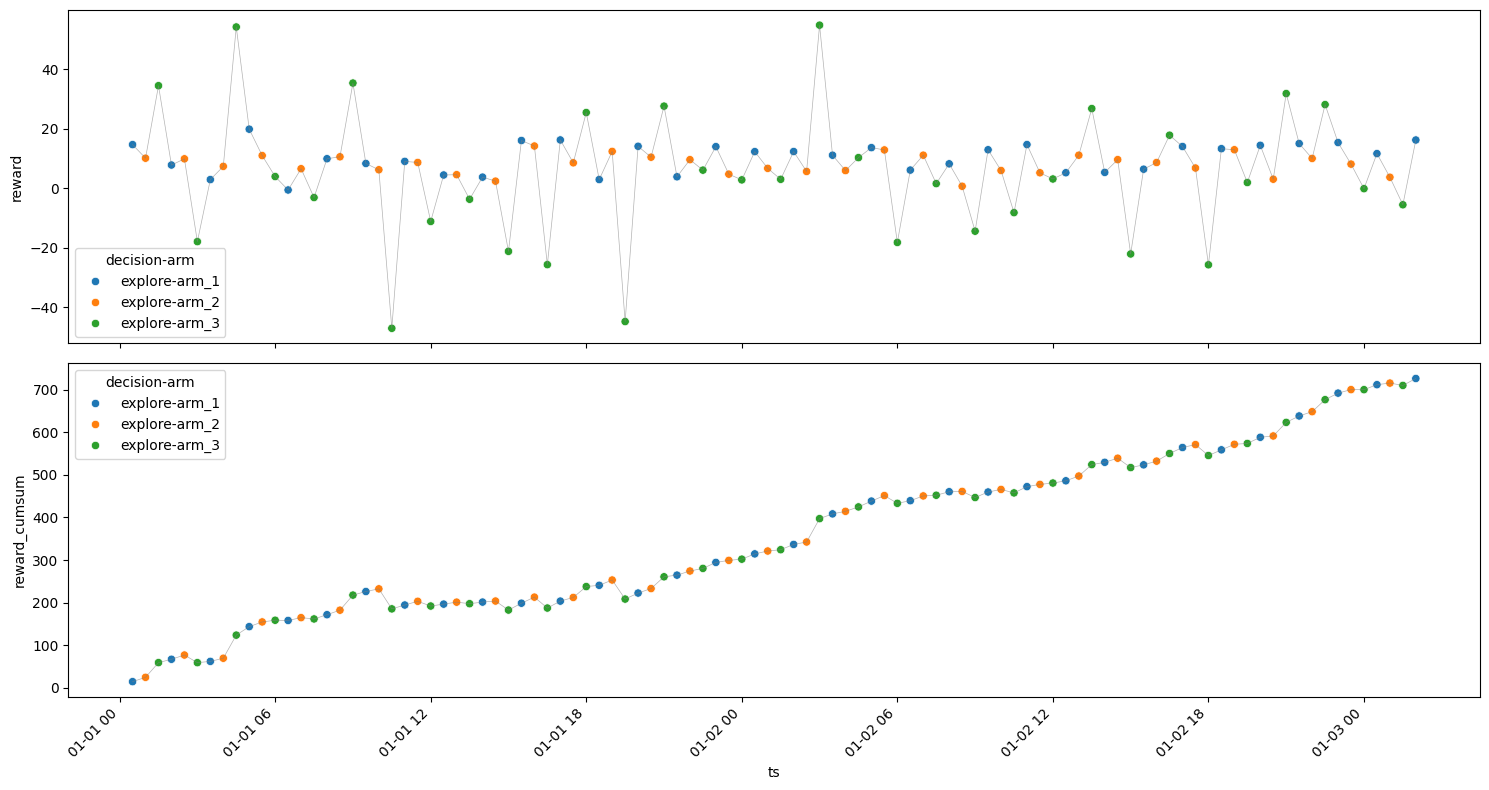

In [14]:
explore_rewarddf = model.rewardsdf
get_metrics(explore_rewarddf)
plot_reward(explore_rewarddf);

## Uniform Exploration

### Algorithm

> 1. For $K$ arms, $T$ rounds 
> 
> 2. Exploration Phase : Try each arm N times 
> 
> 3. Select an arm $\hat{a}$ with highest mean reward 
> 
> 4. Exploitation Phase : use $\hat{a}$ for rest of the rounds


In [15]:
arms_iterator = arms_cyclic_iter(arms)

model = Model(arms)

for _ in range(3):
    model.explore(next(arms_iterator))

for i in range(97):
    model.exploit()

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_1,5.879398,5.879398
1,1,explore,2,2024-01-01 01:00:00,arm_2,8.022709,13.902108
2,1,explore,3,2024-01-01 01:30:00,arm_3,4.994972,18.897080
3,2,exploit,4,2024-01-01 02:00:00,arm_2,6.281499,25.178578
4,2,exploit,5,2024-01-01 02:30:00,arm_2,8.768576,33.947154
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,arm_2,5.323829,806.060974
96,2,exploit,97,2024-01-03 00:30:00,arm_2,10.659535,816.720509
97,2,exploit,98,2024-01-03 01:00:00,arm_2,5.718620,822.439129
98,2,exploit,99,2024-01-03 01:30:00,arm_2,6.567910,829.007039


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,arm_1,explore,1,2024-01-01 00:30:00,5.879398,5.879398,5.879398,5.879398,NaN
2,arm_2,explore,1,2024-01-01 01:00:00,8.022709,8.022709,8.022709,8.022709,NaN
3,arm_3,explore,1,2024-01-01 01:30:00,4.994972,4.994972,4.994972,4.994972,NaN
1,arm_2,exploit,97,2024-01-01 02:00:00,-1.311294,8.454632,16.735225,820.099277,3.371759



        Rounds              : 100
        Optimum Reward      : 845.4631722542013
        Cumulative Reward   : 838.9963569129461 
        Regret              : 6.466815341255142
        


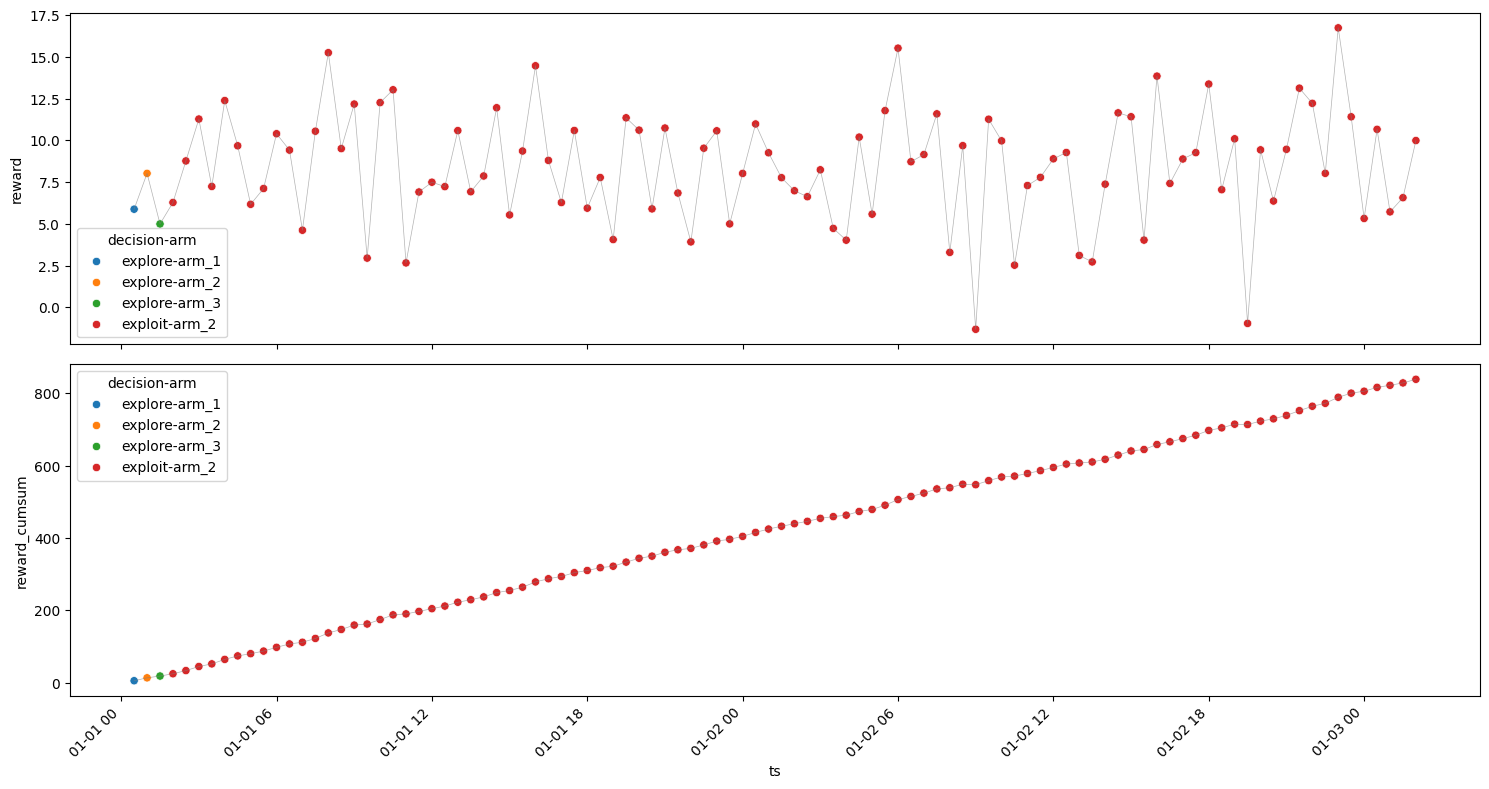

In [16]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf)
plot_reward(exploit_rewarddf);

### Selective Exploitation

#### Arm 1

In [17]:
model = Model(arms)

for _ in range(3):
    model.explore(next(arms_iterator))

model.chosen_arm = "arm_1"

for i in range(97):
    model.exploit()

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_1,1.584226,1.584226
1,1,explore,2,2024-01-01 01:00:00,arm_2,4.575686,6.159912
2,1,explore,3,2024-01-01 01:30:00,arm_3,-46.110331,-39.950419
3,2,exploit,4,2024-01-01 02:00:00,arm_1,8.441025,-31.509394
4,2,exploit,5,2024-01-01 02:30:00,arm_1,16.706485,-14.802909
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,arm_1,-0.027129,887.467501
96,2,exploit,97,2024-01-03 00:30:00,arm_1,8.294347,895.761848
97,2,exploit,98,2024-01-03 01:00:00,arm_1,13.948062,909.709910
98,2,exploit,99,2024-01-03 01:30:00,arm_1,8.986954,918.696864


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,arm_1,explore,1,2024-01-01 00:30:00,1.584226,1.584226,1.584226,1.584226,NaN
2,arm_2,explore,1,2024-01-01 01:00:00,4.575686,4.575686,4.575686,4.575686,NaN
3,arm_3,explore,1,2024-01-01 01:30:00,-46.110331,-46.110331,-46.110331,-46.110331,NaN
0,arm_1,exploit,97,2024-01-01 02:00:00,-0.276465,10.007472,23.195923,970.724770,5.213823



        Rounds              : 100
        Optimum Reward      : 1000.7471851949623
        Cumulative Reward   : 930.7743505778576 
        Regret              : 69.9728346171047
        


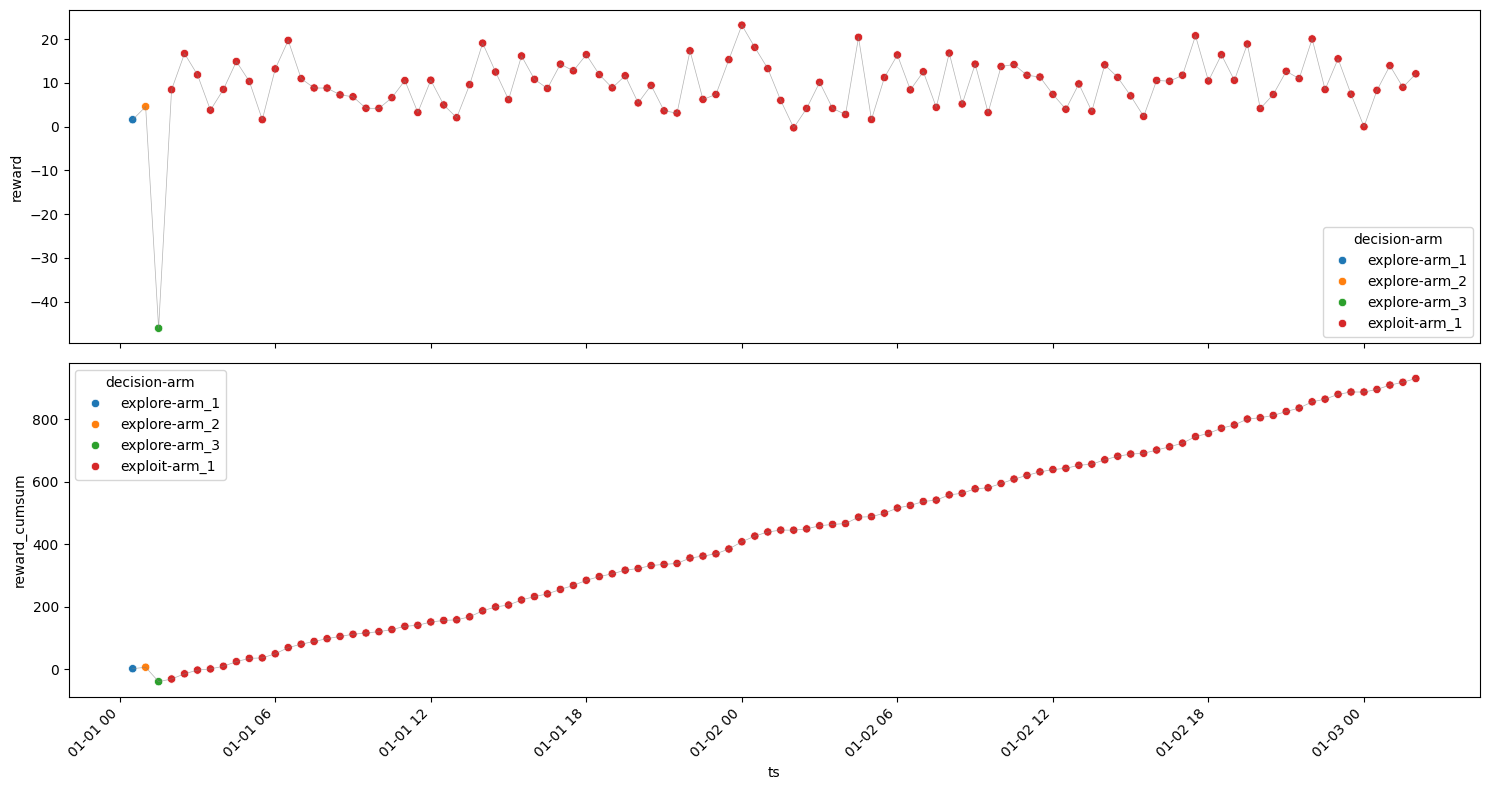

In [18]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf)
plot_reward(exploit_rewarddf);

#### Arm 2

In [19]:
model = Model(arms)

for _ in range(3):
    model.explore(next(arms_iterator))

model.chosen_arm = "arm_2"

for i in range(97):
    model.exploit()

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_1,14.293605,14.293605
1,1,explore,2,2024-01-01 01:00:00,arm_2,5.017779,19.311384
2,1,explore,3,2024-01-01 01:30:00,arm_3,-16.783069,2.528316
3,2,exploit,4,2024-01-01 02:00:00,arm_2,4.583187,7.111502
4,2,exploit,5,2024-01-01 02:30:00,arm_2,5.678105,12.789607
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,arm_2,8.846101,788.602028
96,2,exploit,97,2024-01-03 00:30:00,arm_2,3.746286,792.348314
97,2,exploit,98,2024-01-03 01:00:00,arm_2,2.557700,794.906013
98,2,exploit,99,2024-01-03 01:30:00,arm_2,5.727292,800.633305


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,arm_1,explore,1,2024-01-01 00:30:00,14.293605,14.293605,14.293605,14.293605,NaN
2,arm_2,explore,1,2024-01-01 01:00:00,5.017779,5.017779,5.017779,5.017779,NaN
3,arm_3,explore,1,2024-01-01 01:30:00,-16.783069,-16.783069,-16.783069,-16.783069,NaN
1,arm_2,exploit,97,2024-01-01 02:00:00,0.325208,8.328770,16.413429,807.890684,3.349533



        Rounds              : 100
        Optimum Reward      : 1429.3605254607367
        Cumulative Reward   : 810.4189997093333 
        Regret              : 618.9415257514033
        


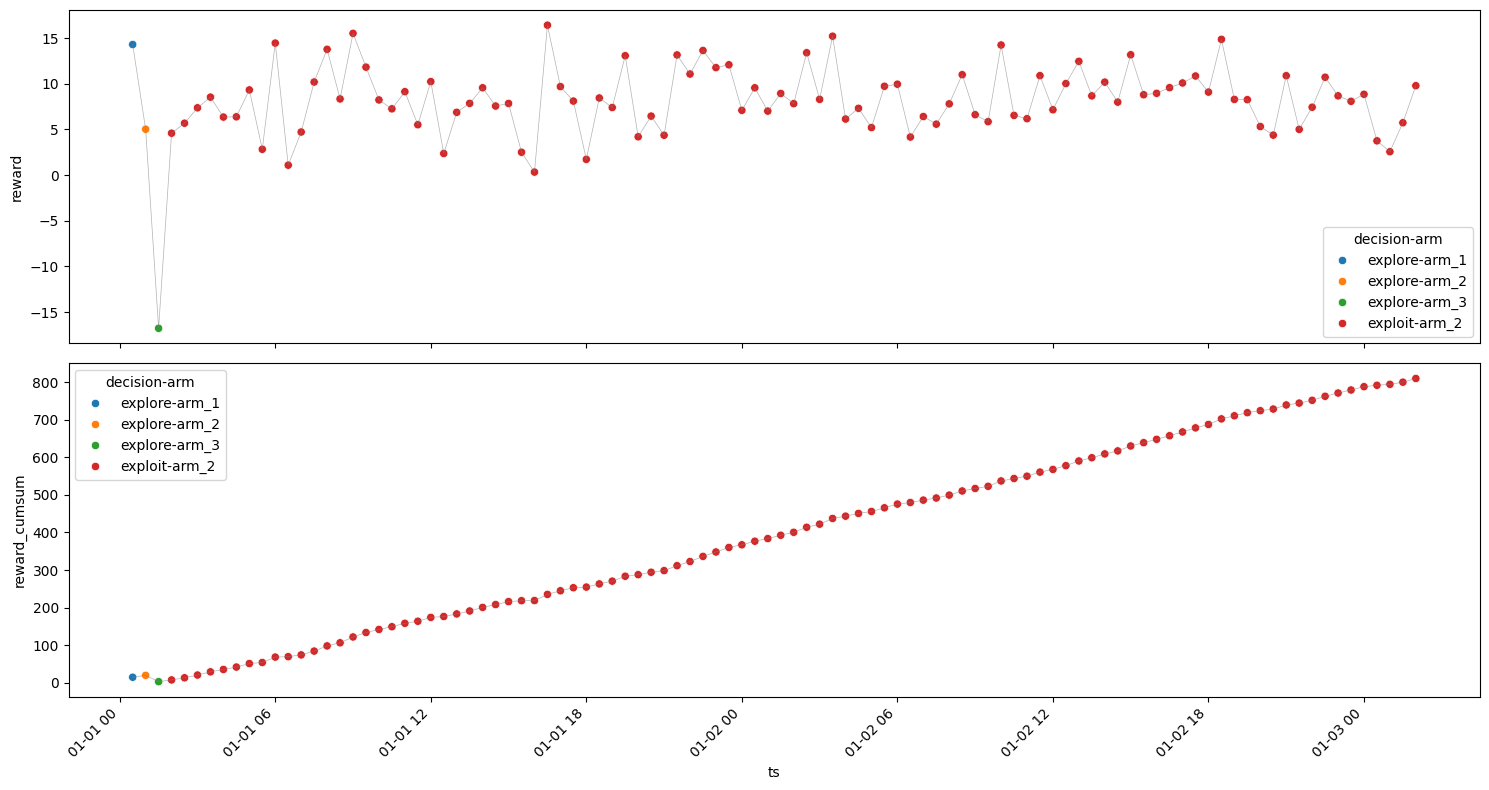

In [20]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf)
plot_reward(exploit_rewarddf);

#### Arm 3

In [21]:
model = Model(arms)

for _ in range(3):
    model.explore(next(arms_iterator))

model.chosen_arm = "arm_3"

for i in range(97):
    model.exploit()

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_1,9.701172,9.701172
1,1,explore,2,2024-01-01 01:00:00,arm_2,8.269244,17.970416
2,1,explore,3,2024-01-01 01:30:00,arm_3,31.149943,49.120360
3,2,exploit,4,2024-01-01 02:00:00,arm_3,-54.441744,-5.321384
4,2,exploit,5,2024-01-01 02:30:00,arm_3,-24.978085,-30.299469
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,arm_3,11.065099,835.878021
96,2,exploit,97,2024-01-03 00:30:00,arm_3,-15.780444,820.097577
97,2,exploit,98,2024-01-03 01:00:00,arm_3,5.832560,825.930137
98,2,exploit,99,2024-01-03 01:30:00,arm_3,-19.050207,806.879931


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,arm_1,explore,1,2024-01-01 00:30:00,9.701172,9.701172,9.701172,9.701172,NaN
1,arm_2,explore,1,2024-01-01 01:00:00,8.269244,8.269244,8.269244,8.269244,NaN
3,arm_3,explore,1,2024-01-01 01:30:00,31.149943,31.149943,31.149943,31.149943,NaN
2,arm_3,exploit,97,2024-01-01 02:00:00,-54.441744,7.979443,57.080189,774.006005,23.401965



        Rounds              : 100
        Optimum Reward      : 3114.9943150453537
        Cumulative Reward   : 823.1263646215909 
        Regret              : 2291.8679504237625
        


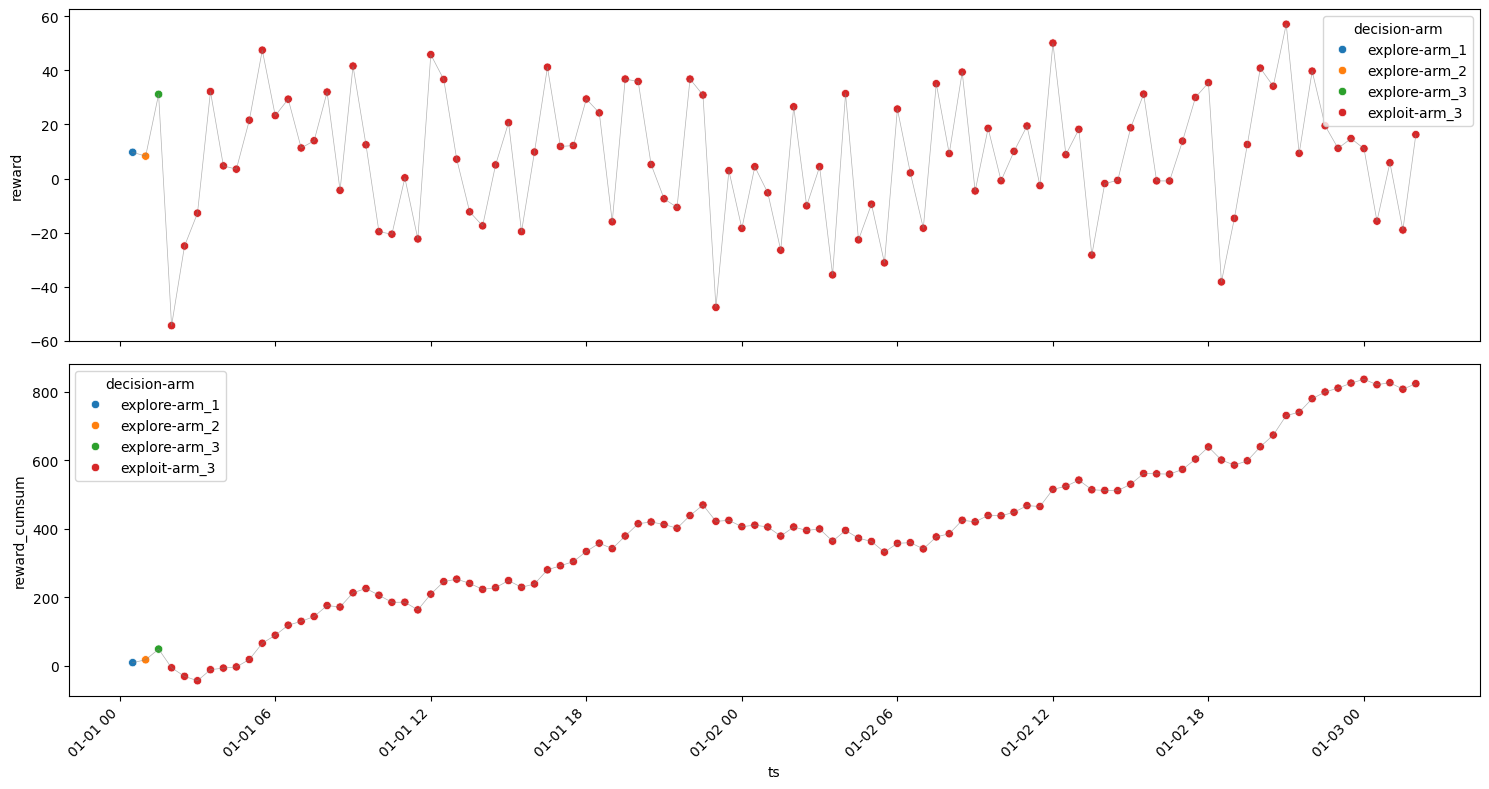

In [22]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf)
plot_reward(exploit_rewarddf);

## Alternative Sequentially Exploration & Exploitation


In [23]:
def explore_exploit(
    n_iterations=100,
    explore_iters=10,
    exploit_iters=10,
    arms=arms,
):

    model = Model(arms)
    run_explore = True

    explore_counter, exploit_counter = 0, 0

    for i in range(n_iterations):
        if run_explore:
            model.explore()
            explore_counter += 1
        else:
            model.exploit()
            exploit_counter += 1

        if explore_counter == explore_iters:
            run_explore = False
            explore_counter = 0

        if exploit_counter == exploit_iters:
            run_explore = True
            exploit_counter = 0

    return model

### Equally Explore & Exploit

In [24]:
model = explore_exploit(
    n_iterations=100,
    explore_iters=10,
    exploit_iters=10,
    arms=["arm_1", "arm_2", "arm_3"],
)

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_3,-39.184432,-39.184432
1,1,explore,2,2024-01-01 01:00:00,arm_3,-2.250016,-41.434448
2,1,explore,3,2024-01-01 01:30:00,arm_3,8.326022,-33.108426
3,1,explore,4,2024-01-01 02:00:00,arm_3,15.703394,-17.405032
4,1,explore,5,2024-01-01 02:30:00,arm_1,10.646341,-6.758691
...,...,...,...,...,...,...,...
95,10,exploit,96,2024-01-03 00:00:00,arm_1,9.047375,786.614477
96,10,exploit,97,2024-01-03 00:30:00,arm_1,3.454034,790.068511
97,10,exploit,98,2024-01-03 01:00:00,arm_1,7.935937,798.004448
98,10,exploit,99,2024-01-03 01:30:00,arm_1,5.877367,803.881815


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
3,arm_3,explore,20,2024-01-01 00:30:00,-62.780166,2.378776,47.756459,47.575522,24.297217
1,arm_1,explore,19,2024-01-01 02:30:00,1.944325,10.068205,18.025927,191.295897,4.819601
2,arm_2,explore,11,2024-01-01 03:00:00,2.590968,7.912387,14.106835,87.036258,4.005542
0,arm_1,exploit,50,2024-01-01 05:30:00,3.263505,9.920276,21.659107,496.013807,4.229813



        Rounds              : 100
        Optimum Reward      : 1006.8205081327129
        Cumulative Reward   : 821.9214841863763 
        Regret              : 184.89902394633657
        


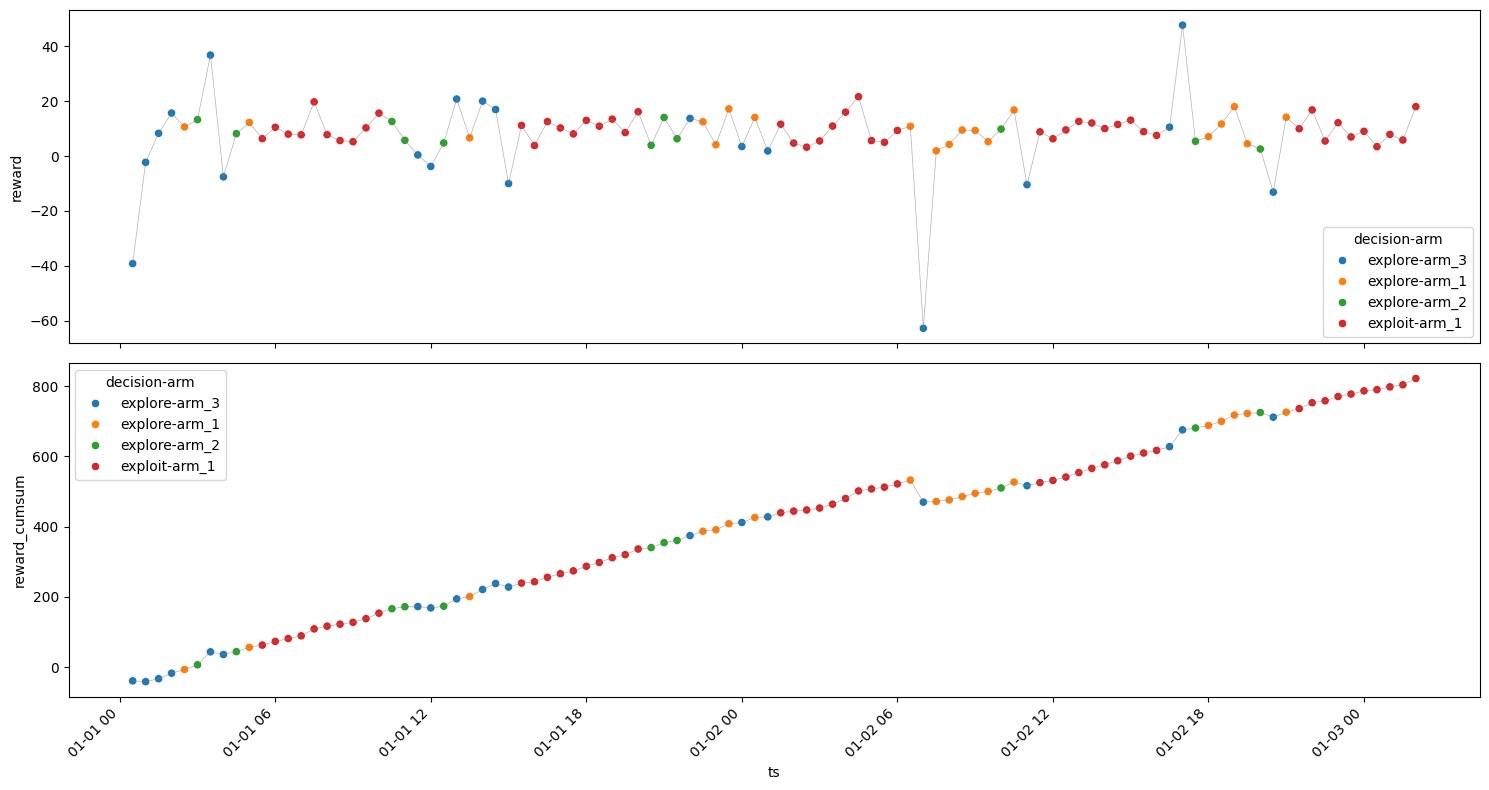

In [25]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf)
plot_reward(experiment_rewarddf);

### Less Explore & More Exploit

In [26]:
model = explore_exploit(
    n_iterations=100,
    explore_iters=5,
    exploit_iters=10,
    arms=arms,
)

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_2,9.242226,9.242226
1,1,explore,2,2024-01-01 01:00:00,arm_3,6.834996,16.077222
2,1,explore,3,2024-01-01 01:30:00,arm_2,3.984192,20.061414
3,1,explore,4,2024-01-01 02:00:00,arm_1,7.456886,27.518300
4,1,explore,5,2024-01-01 02:30:00,arm_1,3.323603,30.841903
...,...,...,...,...,...,...,...
95,14,exploit,96,2024-01-03 00:00:00,arm_2,2.434778,681.921263
96,14,exploit,97,2024-01-03 00:30:00,arm_2,6.428046,688.349309
97,14,exploit,98,2024-01-03 01:00:00,arm_2,8.146294,696.495603
98,14,exploit,99,2024-01-03 01:30:00,arm_2,6.032236,702.527839


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
2,arm_2,explore,16,2024-01-01 00:30:00,3.321153,9.472455,12.793415,151.559277,2.765254
4,arm_3,explore,11,2024-01-01 01:00:00,-11.956004,5.966866,38.700383,65.635525,15.065037
0,arm_1,explore,8,2024-01-01 02:00:00,2.946490,8.701732,19.989582,69.613853,5.662205
3,arm_3,exploit,10,2024-01-01 03:00:00,-34.573848,-1.453645,37.609636,-14.536448,24.937441
1,arm_2,exploit,55,2024-01-01 10:30:00,1.818452,8.006688,14.404394,440.367822,3.353643



        Rounds              : 100
        Optimum Reward      : 947.2454819980799
        Cumulative Reward   : 712.6400299643165 
        Regret              : 234.6054520337634
        


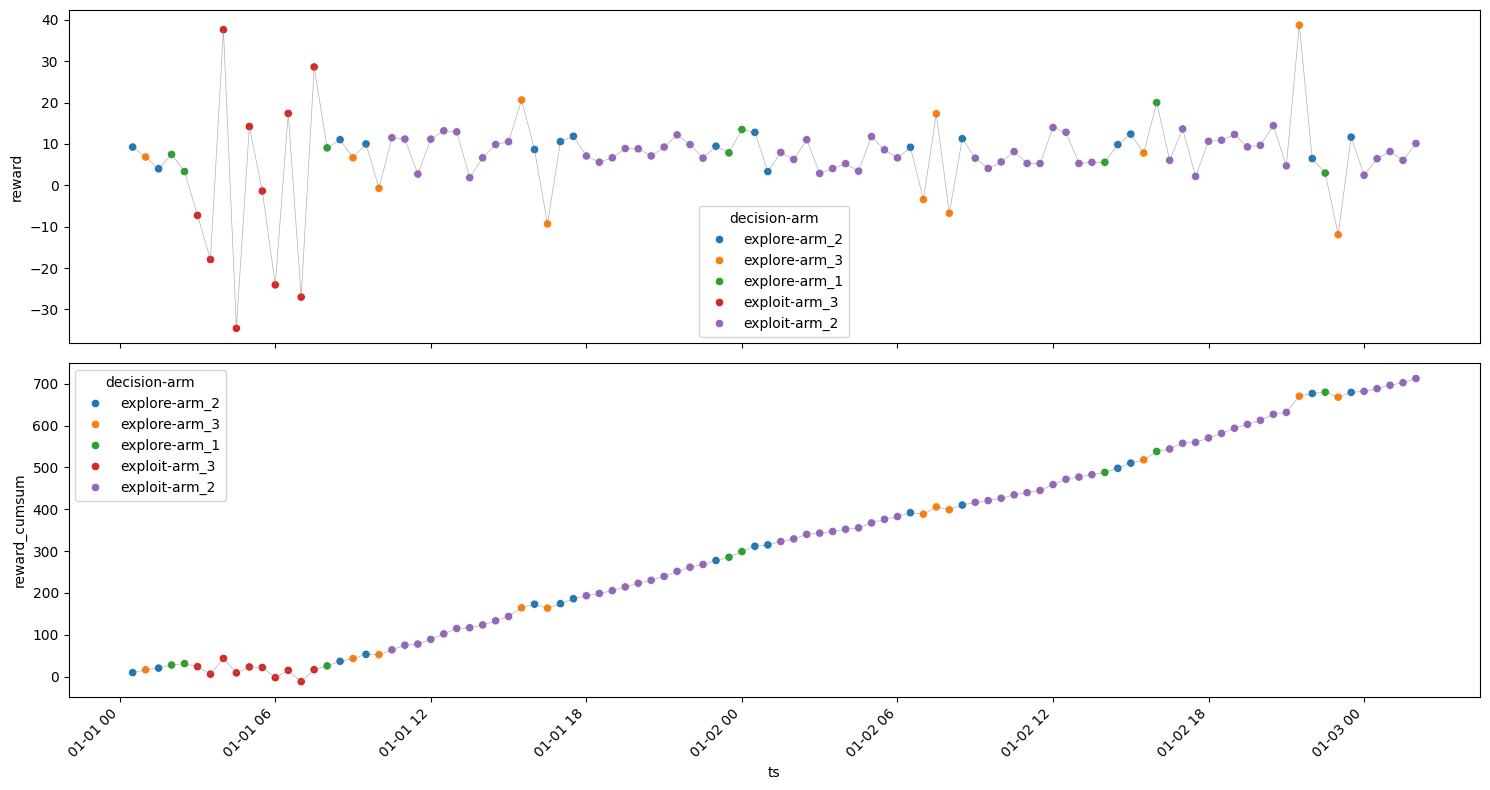

In [27]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf)
plot_reward(experiment_rewarddf);

## Epsilon ($\epsilon$) Greedy


### Algorithm

> 1. for $K$ arms, $T$ rounds
>
> 2. for each round $t \in [T]$
>
>> 1. Toss a coin and generate success probability $\epsilon_t$
>>
>>> 1. if success then explore : choose any arm uniformly at random
>>> 
>>> 2. if failure then exploit : choose an arm with highest average rewards so far

In [28]:
def epsilon_greedy(n_iterations=100, epsilon=0.2, arms=arms):

    model = Model(arms)

    model.explore()

    for i in range(n_iterations):

        p = np.random.random()

        if p < epsilon:
            model.explore()
        else:
            model.exploit()

    return model

### $\epsilon$ = 0.1

In [29]:
model = epsilon_greedy(n_iterations=100, epsilon=0.1, arms=arms)

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_1,13.164255,13.164255
1,1,explore,2,2024-01-01 01:00:00,arm_1,7.513586,20.677841
2,2,exploit,3,2024-01-01 01:30:00,arm_1,14.617776,35.295617
3,2,exploit,4,2024-01-01 02:00:00,arm_1,5.952256,41.247873
4,2,exploit,5,2024-01-01 02:30:00,arm_1,3.362488,44.610361
...,...,...,...,...,...,...,...
96,18,exploit,97,2024-01-03 00:30:00,arm_1,13.497176,923.444317
97,18,exploit,98,2024-01-03 01:00:00,arm_1,9.582637,933.026954
98,18,exploit,99,2024-01-03 01:30:00,arm_1,1.226871,934.253825
99,18,exploit,100,2024-01-03 02:00:00,arm_1,25.016123,959.269948


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,arm_1,explore,5,2024-01-01 00:30:00,7.513586,11.000555,13.164255,55.002775,2.568003
0,arm_1,exploit,33,2024-01-01 01:30:00,1.226871,11.041362,25.016123,364.364938,4.833072
4,arm_3,explore,2,2024-01-01 07:30:00,-3.164411,10.910349,24.985109,21.820698,19.904717
3,arm_3,exploit,58,2024-01-01 08:00:00,-38.117554,8.676521,56.969118,503.238221,24.102827
2,arm_2,explore,3,2024-01-01 10:30:00,8.029772,8.200490,8.305829,24.601471,0.149190



        Rounds              : 101
        Optimum Reward      : 1115.1775375160755
        Cumulative Reward   : 969.0281035361436 
        Regret              : 146.14943397993193
        


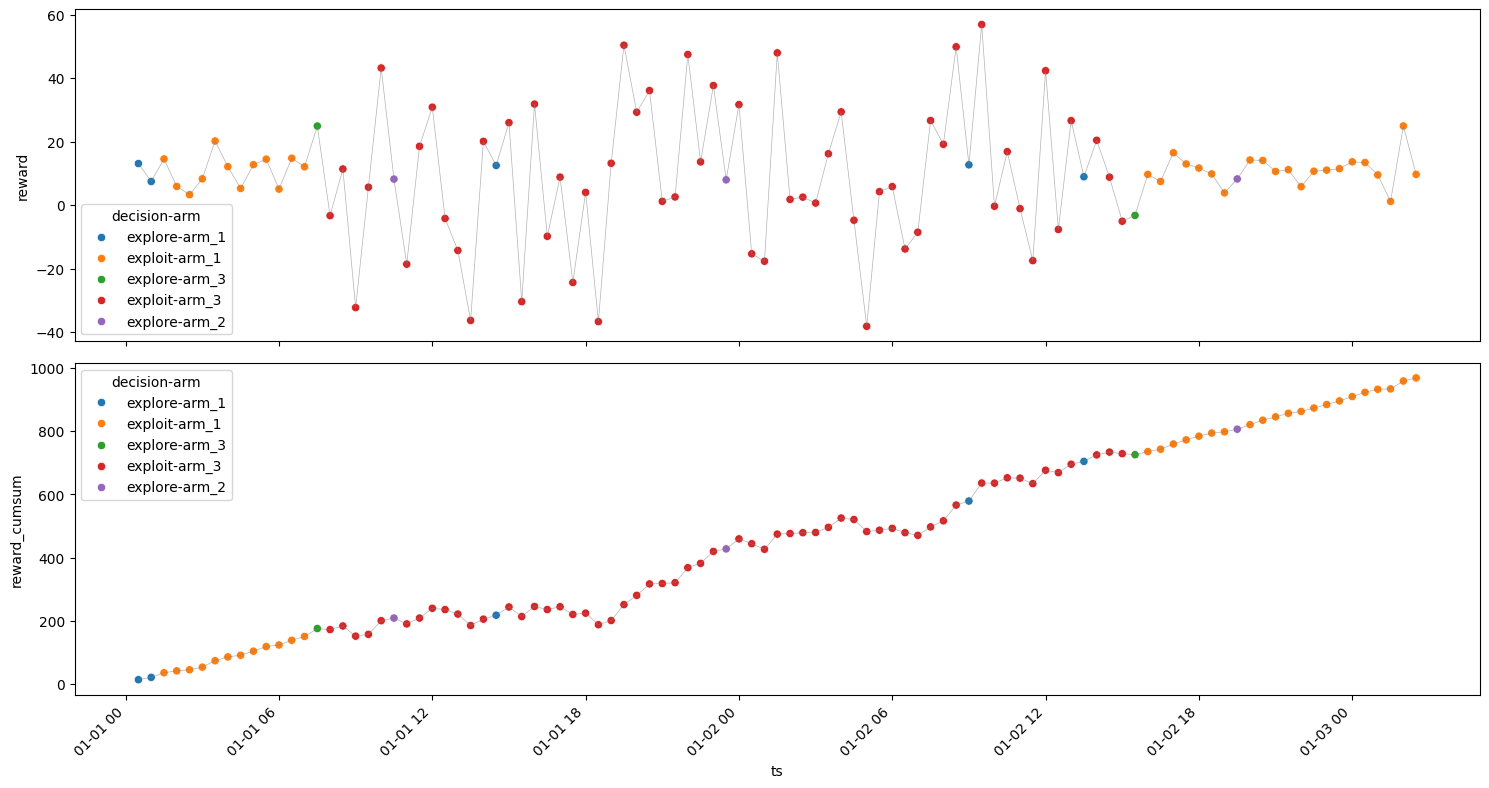

In [30]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf)
plot_reward(experiment_rewarddf);

### $\epsilon$ = 0.2

In [31]:
model = epsilon_greedy(n_iterations=100, epsilon=0.2, arms=arms)

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_2,9.872633,9.872633
1,2,exploit,2,2024-01-01 01:00:00,arm_2,5.260020,15.132653
2,2,exploit,3,2024-01-01 01:30:00,arm_2,10.135395,25.268048
3,2,exploit,4,2024-01-01 02:00:00,arm_2,8.162236,33.430284
4,2,exploit,5,2024-01-01 02:30:00,arm_2,8.573806,42.004090
...,...,...,...,...,...,...,...
96,29,explore,97,2024-01-03 00:30:00,arm_1,9.712263,655.099951
97,30,exploit,98,2024-01-03 01:00:00,arm_3,-1.338992,653.760959
98,30,exploit,99,2024-01-03 01:30:00,arm_3,-4.951924,648.809035
99,30,exploit,100,2024-01-03 02:00:00,arm_3,40.488164,689.297199


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
2,arm_2,explore,10,2024-01-01 00:30:00,3.743866,8.093269,13.298554,80.932688,2.887230
1,arm_2,exploit,8,2024-01-01 01:00:00,4.105006,7.720173,12.241799,61.761386,2.673941
4,arm_3,explore,3,2024-01-01 05:00:00,12.307630,21.670430,31.019323,65.011289,9.355854
3,arm_3,exploit,77,2024-01-01 05:30:00,-44.760957,6.359283,54.824160,489.664770,26.274692
0,arm_1,explore,3,2024-01-01 06:30:00,7.971751,8.612500,9.712263,25.837501,0.956747



        Rounds              : 101
        Optimum Reward      : 2188.713387428091
        Cumulative Reward   : 723.2076348563972 
        Regret              : 1465.5057525716938
        


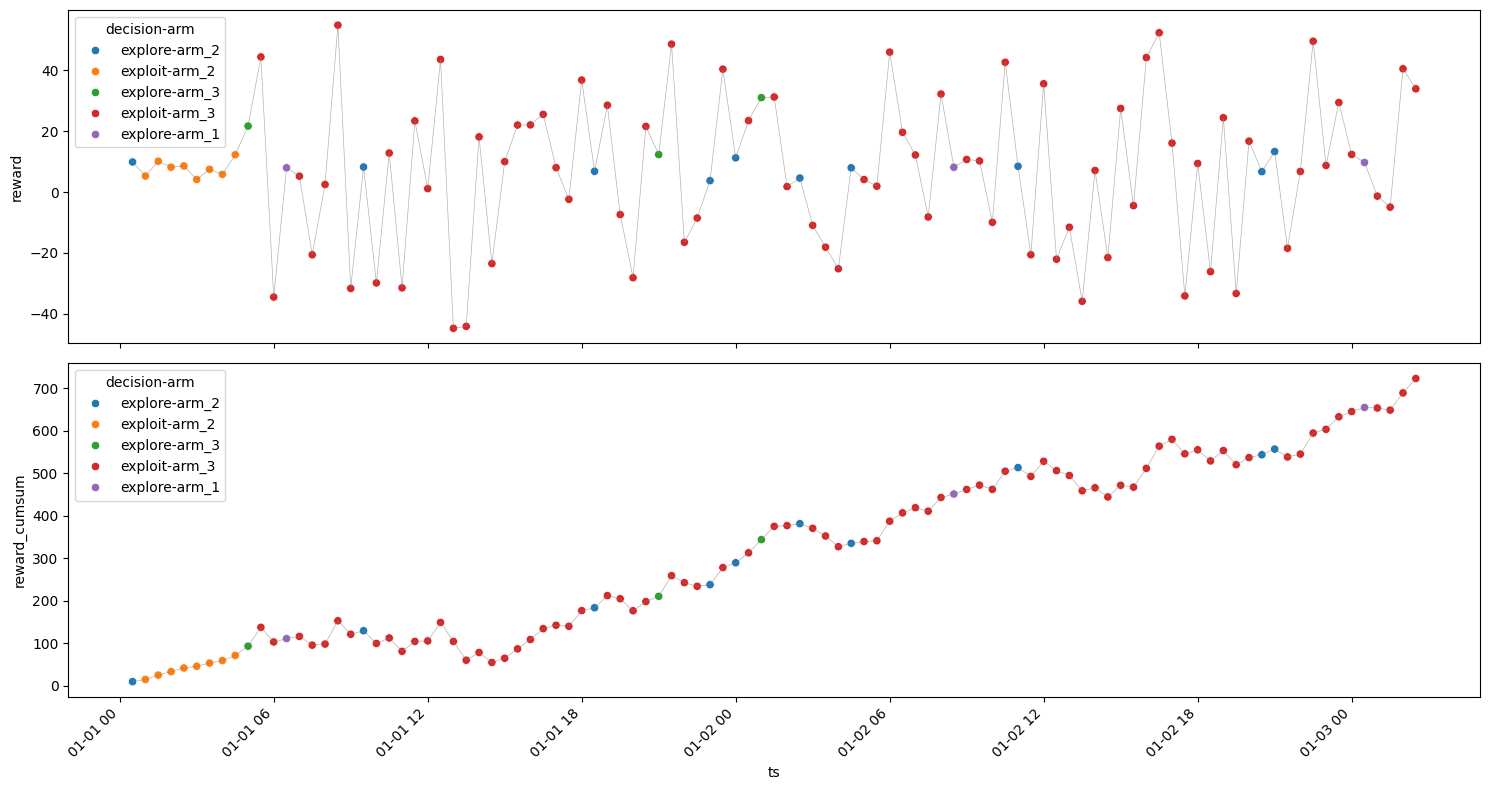

In [32]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf)
plot_reward(experiment_rewarddf);

### $\epsilon$ = 0.4

In [33]:
model = epsilon_greedy(n_iterations=100, epsilon=0.4, arms=arms)

,decision_idx,decision,seq,ts,arm,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,arm_3,24.506117,24.506117
1,2,exploit,2,2024-01-01 01:00:00,arm_3,11.573501,36.079618
2,3,explore,3,2024-01-01 01:30:00,arm_2,7.527144,43.606761
3,4,exploit,4,2024-01-01 02:00:00,arm_3,47.611542,91.218303
4,5,explore,5,2024-01-01 02:30:00,arm_1,4.784452,96.002755
...,...,...,...,...,...,...,...
96,52,exploit,97,2024-01-03 00:30:00,arm_3,4.865530,563.582487
97,52,exploit,98,2024-01-03 01:00:00,arm_3,-20.385035,543.197452
98,53,explore,99,2024-01-03 01:30:00,arm_2,11.271790,554.469242
99,54,exploit,100,2024-01-03 02:00:00,arm_3,36.958096,591.427338


,arm,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
3,arm_3,explore,12,2024-01-01 00:30:00,-54.355821,18.335123,65.663022,220.021473,32.191539
2,arm_3,exploit,67,2024-01-01 01:00:00,-44.863765,2.845487,74.965554,190.647654,25.756657
1,arm_2,explore,12,2024-01-01 01:30:00,2.282932,7.773443,11.271790,93.281310,2.549957
0,arm_1,explore,10,2024-01-01 02:30:00,3.860798,7.947420,14.250761,79.474202,3.907964



        Rounds              : 101
        Optimum Reward      : 1851.8474016216946
        Cumulative Reward   : 583.4246400457904 
        Regret              : 1268.4227615759041
        


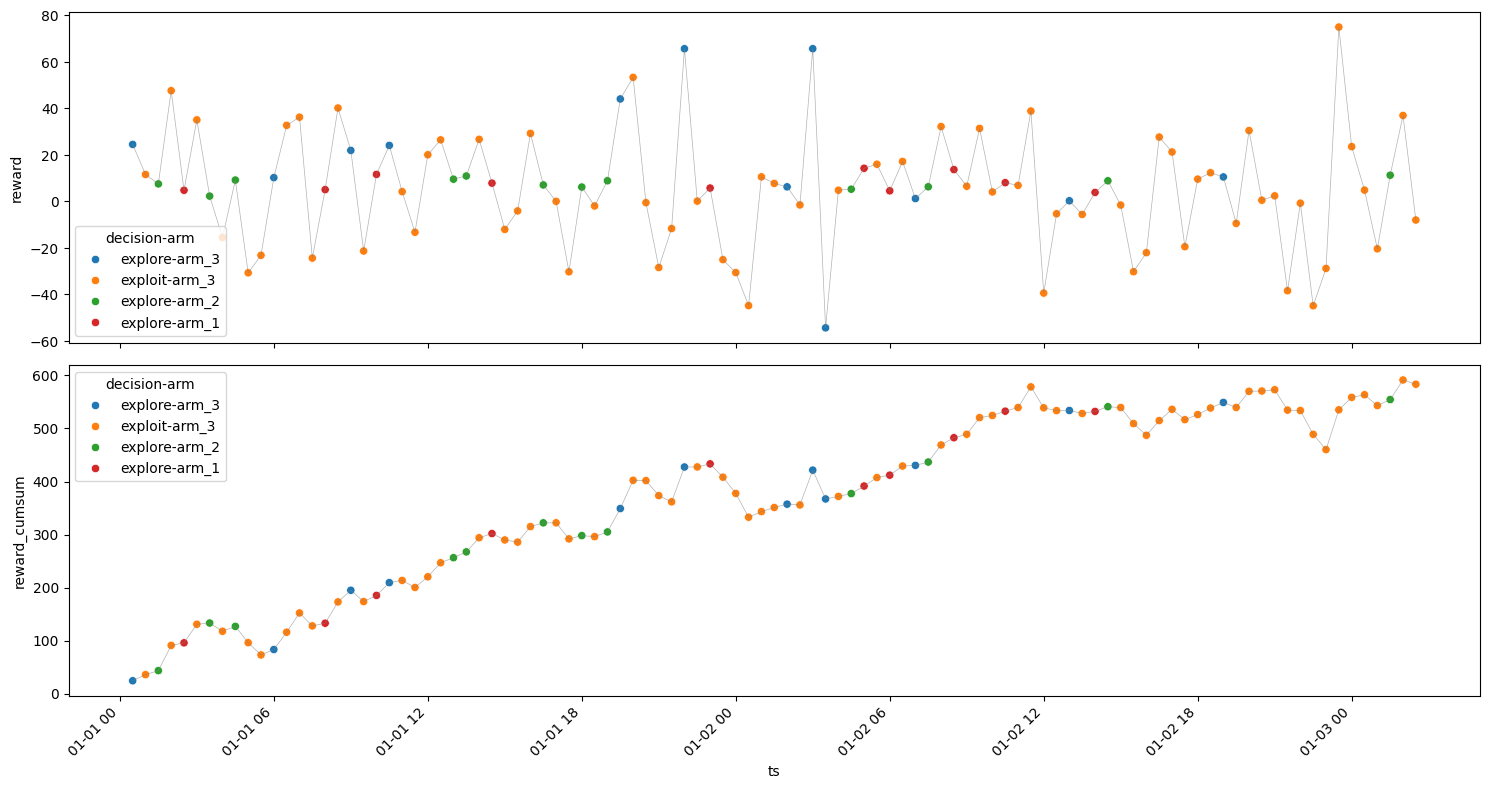

In [34]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf)
plot_reward(experiment_rewarddf);